In [ ]:
l!pip install optuna


     |████████████████████████████████| 302 kB 11.7 MB/s 
     |████████████████████████████████| 164 kB 46.5 MB/s 
     |████████████████████████████████| 80 kB 8.5 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 111 kB 51.7 MB/s 
     |████████████████████████████████| 141 kB 46.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=6af2ee20d3a20a8205d5f3a6b78122004e9ab07f1e48ac58f5a0e97ad80c9483
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
optuna.__version__

'2.9.1'

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow.keras.optimizers
import tensorflow.keras.losses
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.integration import KerasPruningCallback
from optuna.samplers import TPESampler
from optuna.samplers import CmaEsSampler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
LR = 0.0001
EPOCHS = 7
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

i = 0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/COVID/'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            if (i < 500):
              imagePaths.append(os.path.join(dirname, filename))
              i +=1

i = 0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Normal/'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            if (i < 500):
              imagePaths.append(os.path.join(dirname, filename))
              i +=1

i = 0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/Viral Pneumonia/'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            if (i < 500):
              imagePaths.append(os.path.join(dirname, filename))
              i +=1


#Should return length for our dataset.
len(imagePaths) 

1500

/content/drive/MyDrive/Colab Notebooks/COVID-19_Radiography_Dataset/COVID/COVID-3422.png
(299, 299, 3)


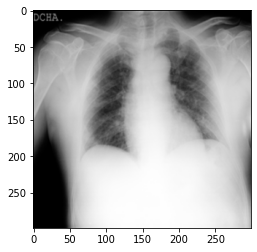

In [ ]:
print(imagePaths[66])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
IMG_SIZE = 224
X = []
y = []


for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(1500, 224, 224, 3) (1500,)


  Labels
0  COVID
1  COVID
2  COVID
3  COVID
4  COVID 

COVID              500
Normal             500
Viral Pneumonia    500
Name: Labels, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



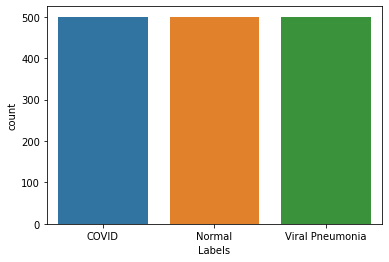

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]] 

[1. 0. 0.] 

<class 'numpy.ndarray'> 

['COVID' 'Normal' 'Viral Pneumonia'] 



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(1125, 224, 224, 3)
(1125, 3)
(375, 224, 224, 3)
(375, 3)


In [ ]:
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf
def cnn():
    base_model1 = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    features1 = base_model1.output
    ######################################################################################################

    base_model2 = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    features2 = base_model2.output
    ######################################################################################################

    #base_model3 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    #features3 = base_model3.output
    conv=tf.keras.layers.concatenate([features1,features2]) #Concatenate the extracted features
    ####################################################################################################

    conv = Sequential()
    #onv.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3))(concatenated))
    conv.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Flatten())
    conv.add(Dropout(rate=dropout))
    conv.add(Dense(512, activation='relu'))
    conv.add(Dropout(rate=dropout))
    conv.add(Dense(64, activation='relu'))
    conv.add(Dense(3, activation='sigmoid'))
    return conv


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.backend import clear_session

def objective(trial):
    if tf.__version__ >= "2":
        monitor = "val_accuracy"
    else:
        monitor = "val_acc"

    tf.keras.backend.clear_session()
    epochs = trial.suggest_int('epochs', 40, 65)
    batch_size = trial.suggest_int('batch_size', 24, 32)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    conv = cnn()

    conv.compile(optimizer= Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    #model.fit(cancer_files_train,train_labels,batch_size=None,epochs=10)
    history = conv.fit(X_train, 
                        y_train, 
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        verbose=1)
    
    score = conv.evaluate(X_test, y_test, verbose=0)
    return history.history[monitor][-1]


#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=10)
#trial = study.best_trial

#print('Accuracy: {}'.format(trial.value))
#print('Best hyperparameters: {}'.format(trial.params))

In [ ]:

if __name__ == "__main__":
    #study = optuna.create_study(sampler=TPESampler())
    #study.optimize(objective, n_trials=10)
    study = optuna.create_study(sampler = optuna.samplers.CmaEsSampler())
    study.optimize(objective, n_trials=15)

    #study.optimize(objective, n_trials=25, timeout=600)
    #pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    #complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    #print("  Number of pruned trials: ", len(pruned_trials))
    #print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))



[I 2021-08-19 09:31:28,200] A new study created in memory with name: no-name-7f4ade57-93e0-4a05-af6c-5e22775b476b


Epoch 1/47
52/52 [==============================] - 39s 159ms/step - loss: 0.5108 - accuracy: 0.5926 - val_loss: 0.3893 - val_accuracy: 0.6889
Epoch 2/47
52/52 [==============================] - 6s 120ms/step - loss: 0.3480 - accuracy: 0.7793 - val_loss: 0.2476 - val_accuracy: 0.8511
Epoch 3/47
52/52 [==============================] - 6s 120ms/step - loss: 0.2733 - accuracy: 0.8311 - val_loss: 0.2435 - val_accuracy: 0.8311
Epoch 4/47
52/52 [==============================] - 6s 119ms/step - loss: 0.2378 - accuracy: 0.8637 - val_loss: 0.2048 - val_accuracy: 0.8756
Epoch 5/47
52/52 [==============================] - 6s 120ms/step - loss: 0.1893 - accuracy: 0.8756 - val_loss: 0.2027 - val_accuracy: 0.8778
Epoch 6/47
52/52 [==============================] - 6s 120ms/step - loss: 0.1718 - accuracy: 0.8926 - val_loss: 0.2067 - val_accuracy: 0.8800
Epoch 7/47
52/52 [==============================] - 6s 121ms/step - loss: 0.1382 - accuracy: 0.9200 - val_loss: 0.1894 - val_accuracy: 0.9000
Epoch

[I 2021-08-19 09:37:16,013] Trial 0 finished with value: 0.9266666769981384 and parameters: {'epochs': 47, 'batch_size': 26, 'lr': 0.0004215227456976838}. Best is trial 0 with value: 0.9266666769981384.


Epoch 1/52
49/49 [==============================] - 10s 148ms/step - loss: 0.5846 - accuracy: 0.5296 - val_loss: 0.4382 - val_accuracy: 0.6978
Epoch 2/52
49/49 [==============================] - 6s 125ms/step - loss: 0.4440 - accuracy: 0.6770 - val_loss: 0.3610 - val_accuracy: 0.7556
Epoch 3/52
49/49 [==============================] - 6s 125ms/step - loss: 0.3930 - accuracy: 0.7200 - val_loss: 0.3314 - val_accuracy: 0.7333
Epoch 4/52
49/49 [==============================] - 6s 125ms/step - loss: 0.3469 - accuracy: 0.7674 - val_loss: 0.2687 - val_accuracy: 0.8222
Epoch 5/52
49/49 [==============================] - 6s 125ms/step - loss: 0.2872 - accuracy: 0.8067 - val_loss: 0.2387 - val_accuracy: 0.8733
Epoch 6/52
49/49 [==============================] - 6s 125ms/step - loss: 0.2524 - accuracy: 0.8489 - val_loss: 0.2367 - val_accuracy: 0.8422
Epoch 7/52
49/49 [==============================] - 6s 126ms/step - loss: 0.2275 - accuracy: 0.8748 - val_loss: 0.2044 - val_accuracy: 0.8667
Epoch

[I 2021-08-19 09:42:45,713] Trial 1 finished with value: 0.9311110973358154 and parameters: {'epochs': 52, 'batch_size': 28, 'lr': 4.876532477045271e-05}. Best is trial 0 with value: 0.9266666769981384.


Epoch 1/52
47/47 [==============================] - 10s 168ms/step - loss: 0.5358 - accuracy: 0.5748 - val_loss: 0.3950 - val_accuracy: 0.6667
Epoch 2/52
47/47 [==============================] - 6s 127ms/step - loss: 0.3760 - accuracy: 0.7496 - val_loss: 0.3102 - val_accuracy: 0.7911
Epoch 3/52
47/47 [==============================] - 6s 128ms/step - loss: 0.3053 - accuracy: 0.8119 - val_loss: 0.2578 - val_accuracy: 0.8533
Epoch 4/52
47/47 [==============================] - 6s 128ms/step - loss: 0.2515 - accuracy: 0.8459 - val_loss: 0.2332 - val_accuracy: 0.8467
Epoch 5/52
47/47 [==============================] - 6s 127ms/step - loss: 0.2088 - accuracy: 0.8793 - val_loss: 0.2024 - val_accuracy: 0.8756
Epoch 6/52
47/47 [==============================] - 6s 128ms/step - loss: 0.1837 - accuracy: 0.8926 - val_loss: 0.1934 - val_accuracy: 0.8822
Epoch 7/52
47/47 [==============================] - 6s 128ms/step - loss: 0.1573 - accuracy: 0.9067 - val_loss: 0.1817 - val_accuracy: 0.8889
Epoch

[I 2021-08-19 09:48:15,537] Trial 2 finished with value: 0.9311110973358154 and parameters: {'epochs': 52, 'batch_size': 29, 'lr': 0.00018383451140882706}. Best is trial 0 with value: 0.9266666769981384.


Epoch 1/53
49/49 [==============================] - 7s 133ms/step - loss: 0.6101 - accuracy: 0.4859 - val_loss: 0.4757 - val_accuracy: 0.7133
Epoch 2/53
49/49 [==============================] - 6s 124ms/step - loss: 0.4347 - accuracy: 0.6896 - val_loss: 0.3530 - val_accuracy: 0.7733
Epoch 3/53
49/49 [==============================] - 6s 124ms/step - loss: 0.3631 - accuracy: 0.7504 - val_loss: 0.2881 - val_accuracy: 0.8244
Epoch 4/53
49/49 [==============================] - 6s 124ms/step - loss: 0.3198 - accuracy: 0.7844 - val_loss: 0.2587 - val_accuracy: 0.8289
Epoch 5/53
49/49 [==============================] - 6s 124ms/step - loss: 0.2675 - accuracy: 0.8489 - val_loss: 0.2132 - val_accuracy: 0.8667
Epoch 6/53
49/49 [==============================] - 6s 124ms/step - loss: 0.2353 - accuracy: 0.8696 - val_loss: 0.2232 - val_accuracy: 0.8733
Epoch 7/53
49/49 [==============================] - 6s 125ms/step - loss: 0.2253 - accuracy: 0.8667 - val_loss: 0.1974 - val_accuracy: 0.8867
Epoch 

[I 2021-08-19 09:54:45,618] Trial 3 finished with value: 0.9222221970558167 and parameters: {'epochs': 53, 'batch_size': 28, 'lr': 5.9153123921054314e-05}. Best is trial 3 with value: 0.9222221970558167.


Epoch 1/52
45/45 [==============================] - 9s 141ms/step - loss: 0.5163 - accuracy: 0.5815 - val_loss: 0.3696 - val_accuracy: 0.7467
Epoch 2/52
45/45 [==============================] - 6s 134ms/step - loss: 0.3469 - accuracy: 0.7778 - val_loss: 0.2293 - val_accuracy: 0.8467
Epoch 3/52
45/45 [==============================] - 6s 131ms/step - loss: 0.2659 - accuracy: 0.8400 - val_loss: 0.2100 - val_accuracy: 0.8733
Epoch 4/52
45/45 [==============================] - 6s 134ms/step - loss: 0.2125 - accuracy: 0.8837 - val_loss: 0.2512 - val_accuracy: 0.8400
Epoch 5/52
45/45 [==============================] - 6s 131ms/step - loss: 0.2062 - accuracy: 0.8704 - val_loss: 0.2011 - val_accuracy: 0.8644
Epoch 6/52
45/45 [==============================] - 6s 130ms/step - loss: 0.1764 - accuracy: 0.8896 - val_loss: 0.2267 - val_accuracy: 0.8378
Epoch 7/52
45/45 [==============================] - 6s 133ms/step - loss: 0.1486 - accuracy: 0.9133 - val_loss: 0.1749 - val_accuracy: 0.9022
Epoch 

[I 2021-08-19 10:00:05,189] Trial 4 finished with value: 0.9266666769981384 and parameters: {'epochs': 52, 'batch_size': 30, 'lr': 0.00025938483827051814}. Best is trial 3 with value: 0.9222221970558167.


Epoch 1/53
49/49 [==============================] - 8s 136ms/step - loss: 0.5581 - accuracy: 0.5274 - val_loss: 0.4191 - val_accuracy: 0.6267
Epoch 2/53
49/49 [==============================] - 6s 129ms/step - loss: 0.4078 - accuracy: 0.7015 - val_loss: 0.3519 - val_accuracy: 0.7667
Epoch 3/53
49/49 [==============================] - 6s 127ms/step - loss: 0.3505 - accuracy: 0.7489 - val_loss: 0.2953 - val_accuracy: 0.8044
Epoch 4/53
49/49 [==============================] - 6s 125ms/step - loss: 0.3062 - accuracy: 0.8059 - val_loss: 0.2415 - val_accuracy: 0.8733
Epoch 5/53
49/49 [==============================] - 6s 127ms/step - loss: 0.2628 - accuracy: 0.8481 - val_loss: 0.2174 - val_accuracy: 0.8711
Epoch 6/53
49/49 [==============================] - 6s 127ms/step - loss: 0.2229 - accuracy: 0.8681 - val_loss: 0.2091 - val_accuracy: 0.8689
Epoch 7/53
49/49 [==============================] - 6s 128ms/step - loss: 0.1937 - accuracy: 0.8859 - val_loss: 0.1991 - val_accuracy: 0.8756
Epoch 

[I 2021-08-19 10:05:43,459] Trial 5 finished with value: 0.9266666769981384 and parameters: {'epochs': 53, 'batch_size': 28, 'lr': 9.117299246455307e-05}. Best is trial 3 with value: 0.9222221970558167.


Epoch 1/53
47/47 [==============================] - 7s 141ms/step - loss: 0.5432 - accuracy: 0.5481 - val_loss: 0.3832 - val_accuracy: 0.6711
Epoch 2/53
47/47 [==============================] - 6s 130ms/step - loss: 0.3695 - accuracy: 0.7378 - val_loss: 0.2895 - val_accuracy: 0.8289
Epoch 3/53
47/47 [==============================] - 6s 130ms/step - loss: 0.2994 - accuracy: 0.8319 - val_loss: 0.2364 - val_accuracy: 0.8578
Epoch 4/53
47/47 [==============================] - 6s 131ms/step - loss: 0.2551 - accuracy: 0.8496 - val_loss: 0.2219 - val_accuracy: 0.8622
Epoch 5/53
47/47 [==============================] - 6s 131ms/step - loss: 0.2227 - accuracy: 0.8630 - val_loss: 0.2035 - val_accuracy: 0.8644
Epoch 6/53
47/47 [==============================] - 6s 130ms/step - loss: 0.1826 - accuracy: 0.8911 - val_loss: 0.1811 - val_accuracy: 0.8911
Epoch 7/53
47/47 [==============================] - 6s 129ms/step - loss: 0.1729 - accuracy: 0.9000 - val_loss: 0.2128 - val_accuracy: 0.8578
Epoch 

KeyboardInterrupt: ignored

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_intermediate_values(study)




### TPE+CMAES





In [ ]:
base_model1 = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
features1 = base_model1.output
    ######################################################################################################

base_model2 = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
features2 = base_model2.output
    ######################################################################################################

    #base_model3 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    #features3 = base_model3.output
conv=tf.keras.layers.concatenate([features1,features2])

171458560/171446536 [==============================] - 7s 0us/step


In [ ]:
from keras.backend import clear_session
clear_session()

def objective(trial):
    if tf.__version__ >= "2":
        monitor = "val_accuracy"
    else:
        monitor = "val_acc"

    tf.keras.backend.clear_session()
    epochs = trial.suggest_int('epochs', 40, 70)
    batch_size = trial.suggest_int('batch_size', 24, 32)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    dropout = trial.suggest_float("dropout_l{}".format(i), 0.5, 0.75)
    #optimiser = trial.suggest_categorical('optimizer', ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl'])
    loss = trial.suggest_categorical('Loss', ['categorical_crossentropy','poisson','kullback_leibler_divergence']) 

    conv = Sequential()
    #onv.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3))(concatenated))
    conv.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Flatten())
    conv.add(Dropout(rate=dropout))
    conv.add(Dense(512, activation='relu'))
    conv.add(Dropout(rate=dropout))
    conv.add(Dense(64, activation='relu'))
    conv.add(Dense(3, activation='sigmoid'))
    
    #optimizer = Adam(lr=1e-3)
    conv.compile(optimizer= tensorflow.keras.optimizers.Adam(learning_rate=lr), loss = loss, metrics=['accuracy'])
    #model.fit(cancer_files_train,train_labels,batch_size=None,epochs=10)
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5),
        TFKerasPruningCallback(trial, monitor),
    ]
    history = conv.fit(X_train, 
                        y_train, 
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        callbacks=callbacks,
                        verbose=1)
    
    score = conv.evaluate(X_test, y_test, verbose=0)
    return history.history[monitor][-1]

study1 = optuna.create_study(sampler = optuna.samplers.TPESampler(), direction='maximize')
study1.optimize(objective, n_trials=5)

pruned_trials = study1.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study1.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study1.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study1.best_trial
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2021-08-20 04:21:21,854] A new study created in memory with name: no-name-51a0616f-9a44-4bbc-9bc2-74f31194016b


Epoch 1/62
41/41 [==============================] - 37s 160ms/step - loss: 0.1557 - accuracy: 0.3333 - val_loss: 1.5873e-05 - val_accuracy: 0.3360
Epoch 2/62
41/41 [==============================] - 5s 123ms/step - loss: 2.0819e-05 - accuracy: 0.3538 - val_loss: 1.1752e-06 - val_accuracy: 0.3520
Epoch 3/62
41/41 [==============================] - 5s 122ms/step - loss: 1.0862e-05 - accuracy: 0.3573 - val_loss: 7.0410e-07 - val_accuracy: 0.3627
Epoch 4/62
41/41 [==============================] - 5s 122ms/step - loss: 1.2498e-05 - accuracy: 0.3556 - val_loss: 3.3156e-07 - val_accuracy: 0.3653
Epoch 5/62
41/41 [==============================] - 5s 122ms/step - loss: 2.1743e-05 - accuracy: 0.3369 - val_loss: -2.2917e-07 - val_accuracy: 0.3653
Epoch 6/62
41/41 [==============================] - 5s 122ms/step - loss: 2.3673e-05 - accuracy: 0.3520 - val_loss: -6.3796e-07 - val_accuracy: 0.3573
Epoch 7/62
41/41 [==============================] - 5s 122ms/step - loss: 9.7729e-06 - accuracy: 0.33

[I 2021-08-20 04:27:05,730] Trial 0 finished with value: 0.3333333432674408 and parameters: {'epochs': 62, 'batch_size': 28, 'lr': 3.7237162686191114e-05, 'dropout_l500': 0.5913710402544755, 'optimizer': 'Adam', 'Loss': 'kullback_leibler_divergence'}. Best is trial 0 with value: 0.3333333432674408.


Epoch 1/42
36/36 [==============================] - 7s 144ms/step - loss: 0.7093 - accuracy: 0.3458 - val_loss: 0.6968 - val_accuracy: 0.3333
Epoch 2/42
36/36 [==============================] - 5s 131ms/step - loss: 0.6978 - accuracy: 0.3653 - val_loss: 0.6874 - val_accuracy: 0.3893
Epoch 3/42
36/36 [==============================] - 5s 132ms/step - loss: 0.6847 - accuracy: 0.4996 - val_loss: 0.6661 - val_accuracy: 0.5973
Epoch 4/42
36/36 [==============================] - 5s 131ms/step - loss: 0.6625 - accuracy: 0.5662 - val_loss: 0.6242 - val_accuracy: 0.5973
Epoch 5/42
36/36 [==============================] - 5s 132ms/step - loss: 0.6241 - accuracy: 0.5973 - val_loss: 0.5827 - val_accuracy: 0.6240
Epoch 6/42
36/36 [==============================] - 5s 132ms/step - loss: 0.6020 - accuracy: 0.6160 - val_loss: 0.5757 - val_accuracy: 0.6187
Epoch 7/42
36/36 [==============================] - 5s 132ms/step - loss: 0.5757 - accuracy: 0.6649 - val_loss: 0.5593 - val_accuracy: 0.6640
Epoch 

[I 2021-08-20 04:31:30,446] Trial 1 finished with value: 0.8613333106040955 and parameters: {'epochs': 42, 'batch_size': 32, 'lr': 2.5374831753872206e-05, 'dropout_l500': 0.6745798126681045, 'optimizer': 'Adadelta', 'Loss': 'poisson'}. Best is trial 1 with value: 0.8613333106040955.


Epoch 1/70
44/44 [==============================] - 8s 141ms/step - loss: 1.0786 - accuracy: 0.3707 - val_loss: 0.9058 - val_accuracy: 0.6667
Epoch 2/70
44/44 [==============================] - 5s 120ms/step - loss: 0.7654 - accuracy: 0.6320 - val_loss: 0.6422 - val_accuracy: 0.6720
Epoch 3/70
44/44 [==============================] - 5s 119ms/step - loss: 0.6255 - accuracy: 0.7147 - val_loss: 0.5415 - val_accuracy: 0.7733
Epoch 4/70
44/44 [==============================] - 5s 119ms/step - loss: 0.5449 - accuracy: 0.7876 - val_loss: 0.4868 - val_accuracy: 0.7973
Epoch 5/70
44/44 [==============================] - 5s 119ms/step - loss: 0.4822 - accuracy: 0.8116 - val_loss: 0.4398 - val_accuracy: 0.8213
Epoch 6/70
44/44 [==============================] - 5s 119ms/step - loss: 0.4268 - accuracy: 0.8267 - val_loss: 0.4148 - val_accuracy: 0.8373
Epoch 7/70
44/44 [==============================] - 5s 120ms/step - loss: 0.3918 - accuracy: 0.8507 - val_loss: 0.3574 - val_accuracy: 0.8507
Epoch 

[I 2021-08-20 04:33:56,932] Trial 2 finished with value: 0.9200000166893005 and parameters: {'epochs': 70, 'batch_size': 26, 'lr': 0.0002194159278335913, 'dropout_l500': 0.6886279251938925, 'optimizer': 'RMSprop', 'Loss': 'categorical_crossentropy'}. Best is trial 2 with value: 0.9200000166893005.


Epoch 1/69
45/45 [==============================] - 8s 125ms/step - loss: 0.1586 - accuracy: 0.3271 - val_loss: 2.4711e-06 - val_accuracy: 0.3653
Epoch 2/69
45/45 [==============================] - 5s 120ms/step - loss: 6.6033e-05 - accuracy: 0.3191 - val_loss: -1.8039e-06 - val_accuracy: 0.3307
Epoch 3/69
45/45 [==============================] - 5s 117ms/step - loss: 1.5647e-05 - accuracy: 0.3351 - val_loss: -2.0144e-06 - val_accuracy: 0.3120
Epoch 4/69
45/45 [==============================] - 5s 121ms/step - loss: 3.2600e-05 - accuracy: 0.3422 - val_loss: -2.2668e-06 - val_accuracy: 0.2987
Epoch 5/69
45/45 [==============================] - 5s 121ms/step - loss: 3.5013e-05 - accuracy: 0.3271 - val_loss: -2.4845e-06 - val_accuracy: 0.2853
Epoch 6/69
45/45 [==============================] - 5s 120ms/step - loss: 2.8182e-05 - accuracy: 0.3200 - val_loss: -2.6823e-06 - val_accuracy: 0.2800
Epoch 7/69
45/45 [==============================] - 5s 116ms/step - loss: 3.4853e-05 - accuracy: 0.

[I 2021-08-20 04:39:00,140] Trial 3 finished with value: 0.3333333432674408 and parameters: {'epochs': 69, 'batch_size': 25, 'lr': 4.619556826126265e-05, 'dropout_l500': 0.6816393930174246, 'optimizer': 'SGD', 'Loss': 'kullback_leibler_divergence'}. Best is trial 2 with value: 0.9200000166893005.


Epoch 1/70
38/38 [==============================] - 9s 166ms/step - loss: 1.0899 - accuracy: 0.3547 - val_loss: 1.0578 - val_accuracy: 0.6107
Epoch 2/70
38/38 [==============================] - 5s 133ms/step - loss: 1.0115 - accuracy: 0.5298 - val_loss: 0.8763 - val_accuracy: 0.6453
Epoch 3/70
38/38 [==============================] - 5s 130ms/step - loss: 0.8508 - accuracy: 0.5884 - val_loss: 0.7343 - val_accuracy: 0.6320
Epoch 4/70
38/38 [==============================] - 5s 131ms/step - loss: 0.7449 - accuracy: 0.6480 - val_loss: 0.6600 - val_accuracy: 0.6400
Epoch 5/70
38/38 [==============================] - 5s 130ms/step - loss: 0.6567 - accuracy: 0.6924 - val_loss: 0.6118 - val_accuracy: 0.6907
Epoch 6/70
38/38 [==============================] - 5s 130ms/step - loss: 0.6388 - accuracy: 0.6942 - val_loss: 0.5870 - val_accuracy: 0.7440
Epoch 7/70
38/38 [==============================] - 5s 130ms/step - loss: 0.6058 - accuracy: 0.7120 - val_loss: 0.5643 - val_accuracy: 0.7253
Epoch 

[I 2021-08-20 04:42:24,057] Trial 4 finished with value: 0.871999979019165 and parameters: {'epochs': 70, 'batch_size': 30, 'lr': 3.373012122935467e-05, 'dropout_l500': 0.6175217440692008, 'optimizer': 'Adadelta', 'Loss': 'categorical_crossentropy'}. Best is trial 2 with value: 0.9200000166893005.


Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.9200000166893005
  Params: 
    epochs: 70
    batch_size: 26
    lr: 0.0002194159278335913
    dropout_l500: 0.6886279251938925
    optimizer: RMSprop
    Loss: categorical_crossentropy


In [ ]:
optuna.visualization.plot_optimization_history(study1)


In [ ]:
!pip install pycopy-copy
!pip install cma

ERROR: File "setup.py" not found for legacy project pycopy-copy from https://files.pythonhosted.org/packages/a3/91/62fdd1a19b718f0b81f0042dd6045f90f1cf00566a49127adf75cb0fd0b3/pycopy-copy-3.3.3.post7.tar.gz#sha256=33b5c42cd8f7d57c371fcc4c137498e7f57119364c6761265c9c6e490e5761dd.


In [ ]:
import copy
import optuna
study_tpe_cmaes = copy.deepcopy(study1)
study_tpe_cmaes.sampler = optuna.integration.PyCmaSampler()
study_tpe_cmaes.optimize(objective, n_trials=5)

Epoch 1/55
41/41 [==============================] - 6s 135ms/step - loss: 0.6862 - accuracy: 0.4382 - val_loss: 0.6137 - val_accuracy: 0.5973
Epoch 2/55
41/41 [==============================] - 5s 124ms/step - loss: 0.5793 - accuracy: 0.6444 - val_loss: 0.5609 - val_accuracy: 0.6053
Epoch 3/55
41/41 [==============================] - 5s 124ms/step - loss: 0.5482 - accuracy: 0.6880 - val_loss: 0.5562 - val_accuracy: 0.5973
Epoch 4/55
41/41 [==============================] - 5s 125ms/step - loss: 0.5267 - accuracy: 0.7511 - val_loss: 0.5068 - val_accuracy: 0.7680
Epoch 5/55
41/41 [==============================] - 5s 125ms/step - loss: 0.4949 - accuracy: 0.8204 - val_loss: 0.4839 - val_accuracy: 0.8267
Epoch 6/55
41/41 [==============================] - 5s 124ms/step - loss: 0.4754 - accuracy: 0.8276 - val_loss: 0.4682 - val_accuracy: 0.8427
Epoch 7/55
41/41 [==============================] - 5s 124ms/step - loss: 0.4577 - accuracy: 0.8507 - val_loss: 0.4642 - val_accuracy: 0.8347
Epoch 

[I 2021-08-20 04:46:58,416] Trial 5 finished with value: 0.9013333320617676 and parameters: {'epochs': 55, 'batch_size': 28, 'lr': 9.476718264853137e-05, 'dropout_l500': 0.5292871885409233, 'optimizer': 'Adadelta', 'Loss': 'poisson'}. Best is trial 2 with value: 0.9200000166893005.


Epoch 1/55
41/41 [==============================] - 6s 131ms/step - loss: 0.7006 - accuracy: 0.3849 - val_loss: 0.6784 - val_accuracy: 0.3653


[I 2021-08-20 04:47:06,087] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/55
41/41 [==============================] - 6s 135ms/step - loss: 0.6977 - accuracy: 0.4160 - val_loss: 0.6673 - val_accuracy: 0.5733
Epoch 2/55
41/41 [==============================] - 5s 123ms/step - loss: 0.6217 - accuracy: 0.6009 - val_loss: 0.5670 - val_accuracy: 0.6853
Epoch 3/55
41/41 [==============================] - 5s 123ms/step - loss: 0.5529 - accuracy: 0.6853 - val_loss: 0.5466 - val_accuracy: 0.7067
Epoch 4/55
41/41 [==============================] - 5s 123ms/step - loss: 0.5333 - accuracy: 0.7333 - val_loss: 0.5112 - val_accuracy: 0.7760
Epoch 5/55
41/41 [==============================] - 5s 123ms/step - loss: 0.5052 - accuracy: 0.7822 - val_loss: 0.5018 - val_accuracy: 0.7973
Epoch 6/55
41/41 [==============================] - 5s 123ms/step - loss: 0.4881 - accuracy: 0.8142 - val_loss: 0.4853 - val_accuracy: 0.8240
Epoch 7/55
41/41 [==============================] - 5s 124ms/step - loss: 0.4790 - accuracy: 0.8187 - val_loss: 0.4861 - val_accuracy: 0.8267
Epoch 

[I 2021-08-20 04:49:35,190] Trial 7 finished with value: 0.8986666798591614 and parameters: {'epochs': 55, 'batch_size': 28, 'lr': 0.0001021968772280764, 'dropout_l500': 0.6321291532193782, 'optimizer': 'Adadelta', 'Loss': 'poisson'}. Best is trial 2 with value: 0.9200000166893005.


Epoch 1/55
41/41 [==============================] - 6s 132ms/step - loss: 0.6972 - accuracy: 0.3956 - val_loss: 0.6651 - val_accuracy: 0.4987


[I 2021-08-20 04:49:43,268] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/55
41/41 [==============================] - 6s 139ms/step - loss: 0.6947 - accuracy: 0.4000 - val_loss: 0.6510 - val_accuracy: 0.5760
Epoch 2/55
41/41 [==============================] - 5s 124ms/step - loss: 0.6081 - accuracy: 0.6098 - val_loss: 0.5648 - val_accuracy: 0.6240
Epoch 3/55
41/41 [==============================] - 5s 124ms/step - loss: 0.5630 - accuracy: 0.6756 - val_loss: 0.5474 - val_accuracy: 0.7227
Epoch 4/55
41/41 [==============================] - 5s 125ms/step - loss: 0.5395 - accuracy: 0.7093 - val_loss: 0.5295 - val_accuracy: 0.7627
Epoch 5/55
41/41 [==============================] - 5s 125ms/step - loss: 0.5176 - accuracy: 0.7493 - val_loss: 0.4967 - val_accuracy: 0.7840
Epoch 6/55
41/41 [==============================] - 5s 124ms/step - loss: 0.4916 - accuracy: 0.8169 - val_loss: 0.4904 - val_accuracy: 0.8000
Epoch 7/55
41/41 [==============================] - 5s 124ms/step - loss: 0.4856 - accuracy: 0.8222 - val_loss: 0.4778 - val_accuracy: 0.8320
Epoch 

[I 2021-08-20 04:52:12,802] Trial 9 finished with value: 0.874666690826416 and parameters: {'epochs': 55, 'batch_size': 28, 'lr': 9.577471303074424e-05, 'dropout_l500': 0.597845229986068, 'optimizer': 'Adadelta', 'Loss': 'poisson'}. Best is trial 2 with value: 0.9200000166893005.


In [ ]:

print("Study statistics: ")
print("  Number of finished trials: ", len(study_tpe_cmaes.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study_tpe_cmaes.best_trial
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  0.9200000166893005
  Params: 
    epochs: 70
    batch_size: 26
    lr: 0.0002194159278335913
    dropout_l500: 0.6886279251938925
    optimizer: RMSprop
    Loss: categorical_crossentropy


In [ ]:
optuna.visualization.plot_optimization_history(study_tpe_cmaes)


In [ ]:
optuna.visualization.plot_intermediate_values(study_tpe_cmaes)

## TPES-TESTING

In [ ]:
#TPES sampler
from keras.backend import clear_session
clear_session()

def objective(trial):
    if tf.__version__ >= "2":
        monitor = "val_accuracy"
    else:
        monitor = "val_acc"

    tf.keras.backend.clear_session()
    epochs = trial.suggest_int('epochs', 40, 70)
    batch_size = trial.suggest_int('batch_size', 24, 32)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    conv = cnn()
    
    #optimizer = Adam(lr=1e-3)
    conv.compile(optimizer= Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    #model.fit(cancer_files_train,train_labels,batch_size=None,epochs=10)
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3),
        TFKerasPruningCallback(trial, monitor),
    ]
    history = conv.fit(X_train, 
                        y_train, 
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        epochs=epochs,
                        callbacks=callbacks,
                        verbose=1)
    
    score = conv.evaluate(X_test, y_test, verbose=0)
    return history.history[monitor][-1]

study1 = optuna.create_study(sampler = optuna.samplers.TPESampler())
#study.optimize(objective, n_trials=10)

study1.optimize(objective, n_trials=15)
pruned_trials = study1.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study1.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study1.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study1.best_trial
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2021-08-19 07:33:10,836] A new study created in memory with name: no-name-4713314c-b07e-489f-9b15-ab70974b3f2d


Epoch 1/44
49/49 [==============================] - 7s 131ms/step - loss: 0.6271 - accuracy: 0.4504 - val_loss: 0.5485 - val_accuracy: 0.6222
Epoch 2/44
49/49 [==============================] - 6s 122ms/step - loss: 0.4872 - accuracy: 0.6304 - val_loss: 0.4094 - val_accuracy: 0.7044
Epoch 3/44
49/49 [==============================] - 6s 123ms/step - loss: 0.4299 - accuracy: 0.6859 - val_loss: 0.3754 - val_accuracy: 0.7511
Epoch 4/44
49/49 [==============================] - 6s 124ms/step - loss: 0.3821 - accuracy: 0.7348 - val_loss: 0.3288 - val_accuracy: 0.7711
Epoch 5/44
49/49 [==============================] - 6s 123ms/step - loss: 0.3432 - accuracy: 0.7585 - val_loss: 0.2684 - val_accuracy: 0.8222
Epoch 6/44
49/49 [==============================] - 6s 124ms/step - loss: 0.3060 - accuracy: 0.8081 - val_loss: 0.2382 - val_accuracy: 0.8489
Epoch 7/44
49/49 [==============================] - 6s 123ms/step - loss: 0.2749 - accuracy: 0.8178 - val_loss: 0.2460 - val_accuracy: 0.8444
Epoch 

[I 2021-08-19 07:35:39,671] Trial 0 finished with value: 0.8955555558204651 and parameters: {'epochs': 44, 'batch_size': 28, 'lr': 3.796427320222813e-05}. Best is trial 0 with value: 0.8955555558204651.


Epoch 1/52
52/52 [==============================] - 7s 126ms/step - loss: 0.5318 - accuracy: 0.5778 - val_loss: 0.3352 - val_accuracy: 0.8067
Epoch 2/52
52/52 [==============================] - 6s 119ms/step - loss: 0.3290 - accuracy: 0.7985 - val_loss: 0.2533 - val_accuracy: 0.8422
Epoch 3/52
52/52 [==============================] - 6s 119ms/step - loss: 0.2511 - accuracy: 0.8511 - val_loss: 0.2201 - val_accuracy: 0.8822
Epoch 4/52
52/52 [==============================] - 6s 118ms/step - loss: 0.2153 - accuracy: 0.8733 - val_loss: 0.2040 - val_accuracy: 0.8778
Epoch 5/52
52/52 [==============================] - 6s 119ms/step - loss: 0.1652 - accuracy: 0.9030 - val_loss: 0.1847 - val_accuracy: 0.8911
Epoch 6/52
52/52 [==============================] - 6s 118ms/step - loss: 0.1510 - accuracy: 0.9163 - val_loss: 0.1615 - val_accuracy: 0.9000
Epoch 7/52
52/52 [==============================] - 6s 118ms/step - loss: 0.1234 - accuracy: 0.9259 - val_loss: 0.1443 - val_accuracy: 0.9178
Epoch 

[I 2021-08-19 07:37:09,003] Trial 1 finished with value: 0.897777795791626 and parameters: {'epochs': 52, 'batch_size': 26, 'lr': 0.0008473347301584612}. Best is trial 0 with value: 0.8955555558204651.


Epoch 1/54
52/52 [==============================] - 7s 127ms/step - loss: 0.5600 - accuracy: 0.4941 - val_loss: 0.4215 - val_accuracy: 0.6711
Epoch 2/54
52/52 [==============================] - 6s 118ms/step - loss: 0.3794 - accuracy: 0.7578 - val_loss: 0.3450 - val_accuracy: 0.7956
Epoch 3/54
52/52 [==============================] - 6s 119ms/step - loss: 0.2906 - accuracy: 0.8222 - val_loss: 0.2420 - val_accuracy: 0.8356
Epoch 4/54
52/52 [==============================] - 6s 119ms/step - loss: 0.2454 - accuracy: 0.8556 - val_loss: 0.2410 - val_accuracy: 0.8467
Epoch 5/54
52/52 [==============================] - 6s 118ms/step - loss: 0.2042 - accuracy: 0.8733 - val_loss: 0.2373 - val_accuracy: 0.8444
Epoch 6/54
52/52 [==============================] - 6s 119ms/step - loss: 0.1752 - accuracy: 0.8896 - val_loss: 0.2050 - val_accuracy: 0.8711
Epoch 7/54
52/52 [==============================] - 6s 118ms/step - loss: 0.1375 - accuracy: 0.9163 - val_loss: 0.1695 - val_accuracy: 0.8956
Epoch 

[I 2021-08-19 07:38:37,756] Trial 2 finished with value: 0.9133333563804626 and parameters: {'epochs': 54, 'batch_size': 26, 'lr': 0.0006222604726094448}. Best is trial 0 with value: 0.8955555558204651.


Epoch 1/59
52/52 [==============================] - 7s 127ms/step - loss: 0.5737 - accuracy: 0.4985 - val_loss: 0.4154 - val_accuracy: 0.6356
Epoch 2/59
52/52 [==============================] - 6s 120ms/step - loss: 0.3820 - accuracy: 0.7244 - val_loss: 0.2930 - val_accuracy: 0.8222
Epoch 3/59
52/52 [==============================] - 6s 120ms/step - loss: 0.3235 - accuracy: 0.7993 - val_loss: 0.2379 - val_accuracy: 0.8378
Epoch 4/59
52/52 [==============================] - 6s 120ms/step - loss: 0.2475 - accuracy: 0.8496 - val_loss: 0.2310 - val_accuracy: 0.8644
Epoch 5/59
52/52 [==============================] - 6s 121ms/step - loss: 0.2277 - accuracy: 0.8519 - val_loss: 0.2187 - val_accuracy: 0.8756
Epoch 6/59
52/52 [==============================] - 6s 120ms/step - loss: 0.1950 - accuracy: 0.8896 - val_loss: 0.1819 - val_accuracy: 0.8867
Epoch 7/59
52/52 [==============================] - 6s 120ms/step - loss: 0.1706 - accuracy: 0.8956 - val_loss: 0.1895 - val_accuracy: 0.8800
Epoch 

[I 2021-08-19 07:40:06,949] Trial 3 finished with value: 0.8933333158493042 and parameters: {'epochs': 59, 'batch_size': 26, 'lr': 0.0001273032982049576}. Best is trial 3 with value: 0.8933333158493042.


Epoch 1/57
50/50 [==============================] - 7s 131ms/step - loss: 0.5701 - accuracy: 0.5259 - val_loss: 0.3699 - val_accuracy: 0.7578
Epoch 2/57
50/50 [==============================] - 6s 124ms/step - loss: 0.3436 - accuracy: 0.7681 - val_loss: 0.2734 - val_accuracy: 0.8067
Epoch 3/57
50/50 [==============================] - 6s 124ms/step - loss: 0.2789 - accuracy: 0.8370 - val_loss: 0.2128 - val_accuracy: 0.8644
Epoch 4/57
50/50 [==============================] - 6s 124ms/step - loss: 0.2364 - accuracy: 0.8578 - val_loss: 0.2029 - val_accuracy: 0.8578
Epoch 5/57
50/50 [==============================] - 6s 124ms/step - loss: 0.1822 - accuracy: 0.8933 - val_loss: 0.1944 - val_accuracy: 0.8800
Epoch 6/57
50/50 [==============================] - 6s 124ms/step - loss: 0.1624 - accuracy: 0.9089 - val_loss: 0.2452 - val_accuracy: 0.8289
Epoch 7/57
50/50 [==============================] - 6s 124ms/step - loss: 0.1386 - accuracy: 0.9215 - val_loss: 0.1756 - val_accuracy: 0.8933
Epoch 

[I 2021-08-19 07:41:28,717] Trial 4 finished with value: 0.897777795791626 and parameters: {'epochs': 57, 'batch_size': 27, 'lr': 0.00024234978368931642}. Best is trial 3 with value: 0.8933333158493042.


Epoch 1/56
52/52 [==============================] - 7s 126ms/step - loss: 0.5206 - accuracy: 0.5674 - val_loss: 0.3580 - val_accuracy: 0.7644


[I 2021-08-19 07:41:41,411] Trial 5 pruned. Trial was pruned at epoch 0.


Epoch 1/62
54/54 [==============================] - 7s 123ms/step - loss: 0.6386 - accuracy: 0.4704 - val_loss: 0.5982 - val_accuracy: 0.6689
Epoch 2/62
54/54 [==============================] - 6s 117ms/step - loss: 0.5659 - accuracy: 0.5844 - val_loss: 0.4844 - val_accuracy: 0.6956
Epoch 3/62
54/54 [==============================] - 6s 118ms/step - loss: 0.4628 - accuracy: 0.6852 - val_loss: 0.4177 - val_accuracy: 0.6444
Epoch 4/62
54/54 [==============================] - 6s 118ms/step - loss: 0.4284 - accuracy: 0.6852 - val_loss: 0.3696 - val_accuracy: 0.7467
Epoch 5/62
54/54 [==============================] - 6s 118ms/step - loss: 0.4052 - accuracy: 0.6963 - val_loss: 0.3565 - val_accuracy: 0.7622
Epoch 6/62
54/54 [==============================] - 6s 118ms/step - loss: 0.3911 - accuracy: 0.7178 - val_loss: 0.3449 - val_accuracy: 0.7600
Epoch 7/62
54/54 [==============================] - 6s 117ms/step - loss: 0.3739 - accuracy: 0.7378 - val_loss: 0.3423 - val_accuracy: 0.7600
Epoch 

[I 2021-08-19 07:45:10,565] Trial 6 finished with value: 0.8844444155693054 and parameters: {'epochs': 62, 'batch_size': 25, 'lr': 1.2019134258427792e-05}. Best is trial 6 with value: 0.8844444155693054.


Epoch 1/57
49/49 [==============================] - 7s 131ms/step - loss: 0.6051 - accuracy: 0.5104 - val_loss: 0.5009 - val_accuracy: 0.6444
Epoch 2/57
49/49 [==============================] - 6s 124ms/step - loss: 0.4587 - accuracy: 0.6674 - val_loss: 0.4126 - val_accuracy: 0.6467
Epoch 3/57
49/49 [==============================] - 6s 123ms/step - loss: 0.4076 - accuracy: 0.6963 - val_loss: 0.3528 - val_accuracy: 0.7467
Epoch 4/57
49/49 [==============================] - 6s 124ms/step - loss: 0.3786 - accuracy: 0.7267 - val_loss: 0.3247 - val_accuracy: 0.7667
Epoch 5/57
49/49 [==============================] - 6s 124ms/step - loss: 0.3492 - accuracy: 0.7563 - val_loss: 0.3302 - val_accuracy: 0.7733
Epoch 6/57
49/49 [==============================] - 6s 123ms/step - loss: 0.3176 - accuracy: 0.7800 - val_loss: 0.2690 - val_accuracy: 0.8133
Epoch 7/57
49/49 [==============================] - 6s 124ms/step - loss: 0.2923 - accuracy: 0.8052 - val_loss: 0.2517 - val_accuracy: 0.8578
Epoch 

[I 2021-08-19 07:47:39,294] Trial 7 finished with value: 0.8822222352027893 and parameters: {'epochs': 57, 'batch_size': 28, 'lr': 3.25850383845482e-05}. Best is trial 7 with value: 0.8822222352027893.


Epoch 1/52
44/44 [==============================] - 10s 165ms/step - loss: 0.5689 - accuracy: 0.5237 - val_loss: 0.4168 - val_accuracy: 0.6822


[I 2021-08-19 07:47:54,938] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/57
49/49 [==============================] - 7s 130ms/step - loss: 0.5741 - accuracy: 0.5222 - val_loss: 0.4109 - val_accuracy: 0.6800


[I 2021-08-19 07:48:07,415] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/70
44/44 [==============================] - 7s 141ms/step - loss: 0.6504 - accuracy: 0.4244 - val_loss: 0.6179 - val_accuracy: 0.6133
Epoch 2/70
44/44 [==============================] - 6s 131ms/step - loss: 0.6017 - accuracy: 0.5793 - val_loss: 0.5632 - val_accuracy: 0.6311
Epoch 3/70
44/44 [==============================] - 6s 130ms/step - loss: 0.5194 - accuracy: 0.6496 - val_loss: 0.4330 - val_accuracy: 0.7444
Epoch 4/70
44/44 [==============================] - 6s 131ms/step - loss: 0.4409 - accuracy: 0.6956 - val_loss: 0.3815 - val_accuracy: 0.7089
Epoch 5/70
44/44 [==============================] - 6s 134ms/step - loss: 0.4115 - accuracy: 0.6926 - val_loss: 0.3543 - val_accuracy: 0.7333
Epoch 6/70
44/44 [==============================] - 6s 133ms/step - loss: 0.3920 - accuracy: 0.7296 - val_loss: 0.3440 - val_accuracy: 0.7489
Epoch 7/70
44/44 [==============================] - 6s 132ms/step - loss: 0.3776 - accuracy: 0.7252 - val_loss: 0.3279 - val_accuracy: 0.7533
Epoch 

[I 2021-08-19 07:51:40,487] Trial 10 finished with value: 0.8866666555404663 and parameters: {'epochs': 70, 'batch_size': 31, 'lr': 1.3514879518125936e-05}. Best is trial 7 with value: 0.8822222352027893.


Epoch 1/65
57/57 [==============================] - 8s 126ms/step - loss: 0.6530 - accuracy: 0.3615 - val_loss: 0.6172 - val_accuracy: 0.5311
Epoch 2/65
57/57 [==============================] - 7s 118ms/step - loss: 0.5977 - accuracy: 0.5548 - val_loss: 0.5452 - val_accuracy: 0.7156
Epoch 3/65
57/57 [==============================] - 7s 119ms/step - loss: 0.5107 - accuracy: 0.6489 - val_loss: 0.4292 - val_accuracy: 0.7222
Epoch 4/65
57/57 [==============================] - 7s 118ms/step - loss: 0.4395 - accuracy: 0.6822 - val_loss: 0.3757 - val_accuracy: 0.7533
Epoch 5/65
57/57 [==============================] - 7s 121ms/step - loss: 0.4131 - accuracy: 0.7059 - val_loss: 0.3657 - val_accuracy: 0.7356
Epoch 6/65
57/57 [==============================] - 7s 120ms/step - loss: 0.3936 - accuracy: 0.7015 - val_loss: 0.3639 - val_accuracy: 0.7467
Epoch 7/65
57/57 [==============================] - 7s 120ms/step - loss: 0.3879 - accuracy: 0.7244 - val_loss: 0.3434 - val_accuracy: 0.7311
Epoch 

[I 2021-08-19 07:54:58,969] Trial 11 finished with value: 0.8755555748939514 and parameters: {'epochs': 65, 'batch_size': 24, 'lr': 1.0155934957231253e-05}. Best is trial 11 with value: 0.8755555748939514.


Epoch 1/66
57/57 [==============================] - 8s 126ms/step - loss: 0.6250 - accuracy: 0.4541 - val_loss: 0.5642 - val_accuracy: 0.6178
Epoch 2/66
57/57 [==============================] - 7s 119ms/step - loss: 0.5027 - accuracy: 0.6215 - val_loss: 0.4113 - val_accuracy: 0.7244
Epoch 3/66
57/57 [==============================] - 7s 119ms/step - loss: 0.4058 - accuracy: 0.7193 - val_loss: 0.3571 - val_accuracy: 0.7178
Epoch 4/66
57/57 [==============================] - 7s 119ms/step - loss: 0.3704 - accuracy: 0.7400 - val_loss: 0.3487 - val_accuracy: 0.7533
Epoch 5/66
57/57 [==============================] - 7s 118ms/step - loss: 0.3575 - accuracy: 0.7452 - val_loss: 0.3168 - val_accuracy: 0.7844
Epoch 6/66
57/57 [==============================] - 7s 118ms/step - loss: 0.3242 - accuracy: 0.7741 - val_loss: 0.3113 - val_accuracy: 0.7889
Epoch 7/66
57/57 [==============================] - 7s 120ms/step - loss: 0.3048 - accuracy: 0.7926 - val_loss: 0.2635 - val_accuracy: 0.8222
Epoch 

[I 2021-08-19 07:58:28,295] Trial 12 finished with value: 0.8911111354827881 and parameters: {'epochs': 66, 'batch_size': 24, 'lr': 2.4824227930676562e-05}. Best is trial 11 with value: 0.8755555748939514.


Epoch 1/63
45/45 [==============================] - 7s 142ms/step - loss: 0.6261 - accuracy: 0.4556 - val_loss: 0.5728 - val_accuracy: 0.5800
Epoch 2/63
45/45 [==============================] - 6s 129ms/step - loss: 0.5095 - accuracy: 0.6193 - val_loss: 0.4126 - val_accuracy: 0.6333
Epoch 3/63
45/45 [==============================] - 6s 129ms/step - loss: 0.4214 - accuracy: 0.7015 - val_loss: 0.3633 - val_accuracy: 0.7533
Epoch 4/63
45/45 [==============================] - 6s 132ms/step - loss: 0.3855 - accuracy: 0.7385 - val_loss: 0.3441 - val_accuracy: 0.7244
Epoch 5/63
45/45 [==============================] - 6s 132ms/step - loss: 0.3607 - accuracy: 0.7459 - val_loss: 0.3223 - val_accuracy: 0.7444
Epoch 6/63
45/45 [==============================] - 6s 132ms/step - loss: 0.3440 - accuracy: 0.7556 - val_loss: 0.2997 - val_accuracy: 0.7933
Epoch 7/63
45/45 [==============================] - 6s 130ms/step - loss: 0.3150 - accuracy: 0.7985 - val_loss: 0.2936 - val_accuracy: 0.8089
Epoch 

[I 2021-08-19 08:00:51,577] Trial 13 finished with value: 0.8933333158493042 and parameters: {'epochs': 63, 'batch_size': 30, 'lr': 2.6929311624997436e-05}. Best is trial 11 with value: 0.8755555748939514.


Epoch 1/47
47/47 [==============================] - 7s 137ms/step - loss: 0.6414 - accuracy: 0.3711 - val_loss: 0.6155 - val_accuracy: 0.6267
Epoch 2/47
47/47 [==============================] - 6s 127ms/step - loss: 0.5992 - accuracy: 0.5704 - val_loss: 0.5583 - val_accuracy: 0.6156
Epoch 3/47
47/47 [==============================] - 6s 127ms/step - loss: 0.5248 - accuracy: 0.6526 - val_loss: 0.4507 - val_accuracy: 0.6289
Epoch 4/47
47/47 [==============================] - 6s 128ms/step - loss: 0.4527 - accuracy: 0.6785 - val_loss: 0.3977 - val_accuracy: 0.6822
Epoch 5/47
47/47 [==============================] - 6s 127ms/step - loss: 0.4159 - accuracy: 0.6970 - val_loss: 0.3691 - val_accuracy: 0.7156
Epoch 6/47
47/47 [==============================] - 6s 127ms/step - loss: 0.4063 - accuracy: 0.7037 - val_loss: 0.3532 - val_accuracy: 0.7600
Epoch 7/47
47/47 [==============================] - 6s 128ms/step - loss: 0.3871 - accuracy: 0.7244 - val_loss: 0.3450 - val_accuracy: 0.7578
Epoch 

[I 2021-08-19 08:05:20,571] Trial 14 finished with value: 0.8711110949516296 and parameters: {'epochs': 47, 'batch_size': 29, 'lr': 1.0102596468396399e-05}. Best is trial 14 with value: 0.8711110949516296.


Study statistics: 
  Number of finished trials:  15
  Number of pruned trials:  3
  Number of complete trials:  12
Best trial:
  Value:  0.8711110949516296
  Params: 
    epochs: 47
    batch_size: 29
    lr: 1.0102596468396399e-05


In [ ]:

optuna.visualization.plot_optimization_history(study1)


In [ ]:
optuna.visualization.plot_intermediate_values(study1)

### MODEL

In [ ]:
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf
LR = 0.0002194159278335913
EPOCHS = 70
BATCH_SIZE = 26
dropout = 0.6886279251938925
def cnn():
    base_model1 = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    features1 = base_model1.output
    ######################################################################################################

    base_model2 = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    features2 = base_model2.output
    ######################################################################################################

    #base_model3 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    #features3 = base_model3.output
    conv=tf.keras.layers.concatenate([features1,features2]) #Concatenate the extracted features
    ####################################################################################################

    conv = Sequential()
    #onv.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3))(concatenated))
    conv.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
    conv.add(MaxPooling2D((2, 2), padding='same'))
    conv.add(Flatten())
    conv.add(Dropout(rate=dropout))
    conv.add(Dense(512, activation='relu'))
    conv.add(Dropout(rate=dropout))
    conv.add(Dense(64, activation='relu'))
    conv.add(Dense(3, activation='sigmoid'))
    return conv

In [ ]:
clear_session()
conv = cnn()
for layer in conv.layers:
  layer.trainable = True


LR = 0.0002194159278335913
EPOCHS = 70
BATCH_SIZE = 26
dropout = 0.6886279251938925
conv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR, decay = LR/EPOCHS), loss='categorical_crossentropy',metrics=['accuracy'])
#, decay = LR/EPOCHS
history = conv.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/70
43/43 [==============================] - 17s 379ms/step - loss: 1.0870 - accuracy: 0.4004 - val_loss: 1.0544 - val_accuracy: 0.3360
Epoch 2/70
43/43 [==============================] - 14s 322ms/step - loss: 0.8587 - accuracy: 0.5732 - val_loss: 0.7259 - val_accuracy: 0.6507
Epoch 3/70
43/43 [==============================] - 14s 317ms/step - loss: 0.7244 - accuracy: 0.6342 - val_loss: 0.6460 - val_accuracy: 0.6533
Epoch 4/70
43/43 [==============================] - 14s 322ms/step - loss: 0.6700 - accuracy: 0.6521 - val_loss: 0.5801 - val_accuracy: 0.6907
Epoch 5/70
43/43 [==============================] - 14s 322ms/step - loss: 0.6156 - accuracy: 0.6806 - val_loss: 0.5593 - val_accuracy: 0.7573
Epoch 6/70
43/43 [==============================] - 14s 315ms/step - loss: 0.5732 - accuracy: 0.7425 - val_loss: 0.5372 - val_accuracy: 0.7013
Epoch 7/70
43/43 [==============================] - 14s 321ms/step - loss: 0.5526 - accuracy: 0.7643 - val_loss: 0.4663 - val_accuracy: 0.7867

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


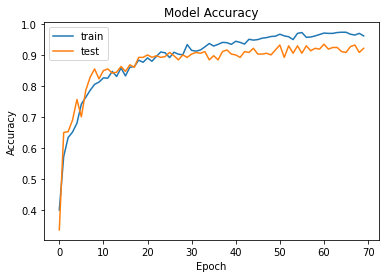

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

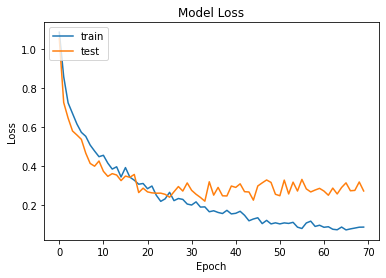

In [ ]:
#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = conv.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

15/15 [==============================] - 1s 45ms/step - loss: 0.2910 - accuracy: 0.8844
Model accuracy on validation dataset: 88.444442.


In [ ]:
y_pred = np.argmax(conv.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[2 0 2 2 2 0 2 1 0 1 0 2 2 0 1 2 0 0 1 0 0 2 1 1 1 1 1 0 1 0 1 1 0 2 0 2 2
 0 1 2 2 2 2 2 2 2 0 1 2 1 0 1 1 2 2 1 1 1 1 2 2 1 0 2 1 0 0 0 0 1 2 1 0 2
 1 1 0 1 1 1 0 0 0 0 1 2 0 1 2 2 1 2 2 1 1 0 0 2 0 1 0 1 1 2 0 1 2 0 0 2 0
 1 0 1 2 2 1 1 2 2 1 2 0 1 0 1 1 1 0 0 0 1 0 0 2 2 2 0 0 1 1 2 0 1 2 0 1 2
 0 0 2 0 0 1 2 2 2 1 0 2 2 1 2 0 1 2 2 1 1 0 0 1 2 1 0 2 1 1 0 2 2 0 0 2 0
 2 0 0 1 1 0 2 2 1 2 2 1 1 2 0 0 0 0 2 2 1 0 2 0 0 0 1 2 1 2 1 2 1 2 0 1 1
 1 2 2 1 1 2 2 1 2 2 2 0 1 1 2 1 1 0 2 0 1 1 2 1 1 0 1 2 2 2 0 2 0 0 0 2 2
 2 0 2 2 1 1 2 0 1 0 2 0 2 1 1 0 1 1 1 2 1 0 2 1 2 0 1 1 1 2 0 2 1 0 0 1 2
 1 0 0 2 1 0 0 1 0 0 1 1 1 0 2 1 0 0 2 1 1 2 2 1 2 0 0 0 0 0 0 1 1 0 1 1 2
 2 1 2 1 1 0 2 2 1 1 2 1 2 1 0 0 2 1 1 0 1 2 0 2 1 1 1 1 1 2 1 2 0 0 2 0 1
 0 2 2 1 2]
375
['COVID' 'Normal' 'Viral Pneumonia']


In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[2 0 2 2 2 0 2 1 0 1 0 2 2 0 1 2 0 0 1 0 0 2 1 1 1 0 1 0 1 0 1 1 0 2 0 2 2
 0 1 2 2 2 2 2 2 2 0 1 2 1 0 1 1 2 2 1 1 1 1 2 2 1 0 2 0 0 0 0 0 1 2 1 0 2
 2 1 0 1 1 1 0 0 0 0 1 0 0 1 2 2 1 2 2 1 1 0 0 2 0 0 0 1 2 2 0 1 2 0 0 2 0
 1 0 1 2 2 1 1 2 2 1 2 0 1 0 0 1 1 0 0 0 1 0 0 2 2 2 0 0 1 0 2 0 1 2 0 1 2
 0 0 2 0 0 0 2 2 2 1 0 1 2 1 2 0 0 2 2 1 1 0 0 1 2 1 0 2 1 1 0 2 1 0 0 2 0
 2 0 0 1 1 0 2 2 1 2 2 0 1 2 0 0 0 0 2 2 1 2 2 0 0 0 1 2 1 2 1 2 1 2 0 1 1
 2 2 2 1 1 2 2 1 2 2 2 0 1 0 2 0 1 0 2 0 1 1 2 1 1 0 1 2 2 2 0 2 0 0 0 2 2
 2 0 2 2 1 0 2 0 1 0 2 0 2 1 1 1 1 1 1 2 1 0 2 1 2 0 1 1 1 2 0 2 1 0 0 1 2
 1 0 0 2 1 1 0 1 0 0 1 1 1 0 2 0 0 0 2 1 1 2 2 1 1 2 0 1 0 0 1 1 1 0 1 1 2
 2 1 2 1 1 0 2 2 1 1 2 0 2 1 0 0 2 1 1 0 1 2 0 2 1 0 1 1 1 2 2 2 0 0 2 0 1
 0 2 1 1 2]
375


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[110  14   1]
 [  4 117   4]
 [  2   4 119]]


,COVID,Normal,Viral Pneumonia
COVID,110,14,1
Normal,4,117,4
Viral Pneumonia,2,4,119


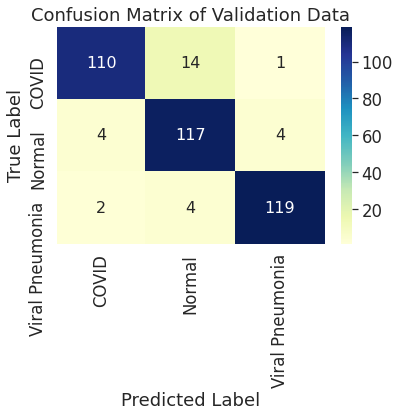

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_labels, y_pred, target_names=['COVID', 'Normal', 'Viral Pneumonia']))


Classification Report

                 precision    recall  f1-score   support

          COVID       0.93      0.88      0.90       176
         Normal       0.87      0.90      0.89       175
Viral Pneumonia       0.96      0.98      0.97       175

       accuracy                           0.92       526
      macro avg       0.92      0.92      0.92       526
   weighted avg       0.92      0.92      0.92       526

